# Simulation of the delivery time of a package under different delay factors
A Open Mini Challle by by Mykhailo Andrusiak and Alexis Boser Makaratzis

Modul WER

Springsemester 2025, FHNW/HSI/DS

## 1. Question

### What we want to know:


What is the probability that a parcel sent from a German distribution hub to the Basel Gateway arrives on time (within two days), considering potential delays caused by weather disruptions, labor strikes, and network congestion?

Motivation:
Standard parcel logistics assume a delivery time of two working days under normal conditions. However, disruptions in the delivery chain such as strong weather events, infrastructure congestion during peak shopping periods, and labor strikes can significantly alter this. By simulating these risks, we aim to quantify the likelihood of delay, and identify which risk factors most significantly impact delivery reliability.

---



## 2. System definition

### We assume:

 1. Every parcel is sent from a hub along the same route to the final node.
2. The standard delivery time (not express) is up to 2 days under normal conditions. We assume 2 days.
    This assumption is based on data from DHL[^1]. Other private distributors have same or similar delivery times.
3. Hub and node are assumed to be in the same country to avoid international supply chain delays.
    As Basel is on the border to Germany and «is the most important logistics location in Switzerland.»[^2], we assumed arriving at the borders in Basel is the same as arriving in the hub.
4. Parcel characteristics[^6]:

    - Every sent unit is a parcel and not a letter
    - Weights are < 2.0 kg
    - Sizes are over 15 x 11 x 1 and under 120 x 60 x 60 cm



[^1]: https://www.dhl.de/en/privatkunden/pakete-versenden/online-frankieren.html?type=ShipmentEditorProductSelection&tid=hp-teaser-minimodul-pak31

[^2]: https://www.logistikcluster-regionbasel.ch/logistikstandort/facts-figures/die-schweizerischen-rheinhaefen/

[^6]: https://www.dhl.de/en/privatkunden/pakete-versenden/deutschlandweit-versenden/versand-bis-2kg.html

### We do **not** model:

- **«Last Mile/ Capillary Deliveries»** from the last node to the final receiver. This exceeds our scope here.
- **«Time of Day» Effects**, such as a business hours and handovers. This exceeds our scope here.
- **All parcel sizes.** Outside of our set size, delivery times are too irregular,  because oversize parcels are not clearly defined.
- **All parcel weights** Outside of our set weight, delivery times are too irregular, because overweight parcels are not clearly defined.
- **Weekdays and weekends.** We are not adjusting to reduced processing speed. Finding and processing this data exceeds our scope.
- **Delays at the Swiss- German Border**. To simplify our model.
- **Large scale disruptions** such as pandemics, war scenarios or comparable crisis scenarios. This exceeds our scope here.
- **Queuing effects** building solely on queuing theory models such as M/M/1. Sadly exceeds our scope here.
- **Sensitiviy Testing.**  due to time constraints and the complexity this exceeds our scope here.
- **Scenario comparison**: Impact analysis of individual events or event combinations compared to the baseline scenario.

---

### Relevant events (“Ereignisse”):

 Package arrives within 2 Days:[^7]		**In time**

 Package arrives after 2 Days:		**delayed**

[^7]: https://www.dhl.de/en/privatkunden/pakete-versenden/deutschlandweit-versenden/versand-bis-2kg.html
---

### Relevant random variables affecting delays:

#### 1. Weather condition variables (independent and dependent):

We model precipitation consisting of Ice, Snow and Rain and Wind. Some of these variables are independent, others are not.

| **Weather Event**                                 | **Independent**   | **Condition**                                                                                                                                                                                                                                                                                                  | **Interacts With**                                                | **Probability Distribution**                                                                                                                          |
| ------------------------------------------------- | ----------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------- |-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Heavy Snow**                                    | Yes               | Occurs if:  <br>- A random number from 0 to 1 is lower than the Probability for heavy snow  <br><br> P (HIGH\_SNOW\_PROB) = 0.05                                                                                                                                                                               | Blocks normal snow and rain <br><br> Part of storm if wind occurs | Bernoulli; Rare independent event: either happens or not.                                                                                             |
| **Normal Snow**                                   | Yes (conditional) | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for snow (P (SNOW\_PROB) = 0.17) and <br><br> if heavy snow does not occur                                                                                                                                                          | Blocks rain <br><br> Part of storm if wind occurs                 | Conditional Bernoulli; Less intense snow, mutually exclusive with heavy snow.                                                                         |
| **Rain**                                          | Yes (conditional) | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for rain (P (RAIN\_PROB) = 0.05) and <br><br> if heavy snow or normal snow does not occur                                                                                                                                           | Part of storm if wind occurs                                      | Conditional Bernoulli; Occurs only when snow didn’t happen.                                                                                           |
| **Wind**                                          | Yes               | Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for wind (P (WIND\_PROB) = 0.01)                                                                                                                                                                                                    | Part of storm                                                     | Bernoulli; Rare independent event: either happens or not.                                                                                             |
| **Regular Ice**<br>And<br>**Ice after high Snow** | Yes               | Regular Ice Occurs if:  <br> A random number from 0 to 1 is lower than the Probability for Ice (P (ICE\_PROB) = 0.31 ) <br><br> Ice after high Snow occurs if:  <br> High snow occurs and <br> a random number from 0 to 1 is lower than the Probability for Ice after snow (P (ICE\_AFTER\_SNOW\_PROB) = 0.4) | More likely after heavy snow (from P of 0.31 to 0.4)              | Bernoulli +  conditional Bernoulli; Ice can occur independently or more likely after heavy snow.                                                      |
| **Storm**                                         | No (Derived)      | Occurs if:  <br> Wind AND (rain OR normal snow OR heavy snow) occur                                                                                                                                                                                                                                            | Overrides individual delays of wind, rain, and both snows         | Logical combination of Bernoulli-distributed variables (wind, rain, normal snow, heavy snow), hence not sampled directly but built from other events. |






**Sources:**

---

#### 2. Strikes in the transport sector (independent variable)

***Strike-Based Delay Model Summary (Germany, 2014–2024)***
Due to the absence of relevant strikes in Switzerland during 2014–2024, we shifted our scope to Germany, where logistic-related strikes are more frequent. We focused on strikes affecting:

- Seaports
- Air cargo
- Rail freight
- Postal services


We collected strike events in a data table across a timespan of ten years and applied the following assumptions:

**Unit of Observation:** Each strike counts as one occurrence, regardless of duration.

**Split Events:** Disjointed periods of the same strike were counted separately.

**Duration Binning:**

Short Strikes: ≤ 3 days

Long Strikes: > 3 days

This yielded:

| **Category**  | **Definition**           | **Occurrances** | **Probability** | **Avg. Delay (days)** | **Probability Distribution** |
| ------------- | ------------------------ | --------------- | --------------- | --------------------- | ---------------------------- |
| Short Strikes | Strikes lasting ≤ 3 days | 19              | 0.0052          | 1.61                  | Bernoulli     |
| Long Strikes  | Strikes lasting > 3 days | 5               | 0.0014          | 8.6                   | Bernoulli      |


**Sources:** All strikes are backed by sources.

---

#### 3. Overload  in the logistic networks

To capture delays caused by overloaded distribution hubs, we introduced congestion as a third variable. We distinguish:

**Independent congestion** (e.g., Christmas season spikes)

**Dependent congestion** (e.g., post-weather-event backlogs)

While we initially explored queuing theory (e.g., M/M/1 model), implementing it would require a secondary model beyond our Monte Carlo framework — exceeding the scope of this project. As a result, we opted for a simplified structure using subvariables to represent both types of congestion.

---

##### 3.1 Independent network congestion variable


We simulate regular seasonal overloads at distribution hubs during peak demand periods in germany.
This occurs when the arrival rate of parcels exceeds the service rate per given time interval:

- **Weeks 47–52**: Pre-Christmas shopping (e.g., Black Friday, Cyber Monday) [^3]
- **Week 1**: Post-holiday returns and New Year sales [^4]

These **6 weeks** represent periods of elevated parcel volume and increased network strain.

**Calculated probability**:
- INDEPENDENT_CONGESTION_PROB = 6 / 52 ≈ 0.1153 ≈ 0.12

**Assumed delay**:
- No precise data available → uniform delay of **1–2 days**

**Probability Distribution**:

- This is a binary outcome fits a bernoulli distribution.


[^3]: https://ecommercenews.eu/dhl-hikes-parcel-rates-in-peak-season/

[^4]: https://www.fulfillmenteurope.com/other/seasonal-peaks/

---

##### 3.2 Dependent network congestion variable


Some congestion events are not seasonal but occur **as a consequence of other disruptions**, such as weather events or strikes. These **dependent congestions** reflect the **secondary strain** on logistics networks — for example, backlog buildup after a snowstorm or delayed rerouting during a strike.

We model this with conditional probabilities: each disruptive event has a likelihood of causing follow-up congestion, as shown below.

| **Trigger Event**      | **Congestion Probability** |
|------------------------|-----------------------------|
| Wind                   | 0.10                        |
| Rain                   | 0.20                        |
| Snow                   | 0.30                        |
| Heavy Snow             | 0.50                        |
| Ice                    | 0.40                        |
| Short Strike           | 0.60                        |
| Long Strike            | 0.80                        |

If a trigger event occurs, a Bernoulli trial is run using the corresponding probability to determine whether congestion follows.

**Assumed delay**:
For all dependent congestion cases, we assume a random delay of 1–3 days.
Looking at the data this Range is on the lower end [^5]. But as we already account for the delay caused by the conditional event, we opted for this range.

**Probability Distribution**:

- The occurrence of dependent congestion is a binary outcome and is modeled using a Bernoulli distribution.

**Sources**: We could not find data in a reasonable timeframe and therefore made our best realistic and conservative estimates.



[^5]: https://www.railfreight.com/business/2024/06/20/weather-becomes-a-delaying-factor-for-german-rail-again/

---

## 3. Solution Strategy

### Basis for Modeling Probabilities

The probabilities of disruption events  are modeled based on the following sources:

- **Data sources:** Wherever we used publicly available data, footnotes link to the sources. We always aimed for the most direct and reliable source. If that is not the case, then because we could not find any other.
- **Assumptions:** For events lacking sufficient data, realistic and conservative estimates are made based on our best assumptions. Whenever we made assumptions, we clearly stated it.
- **Literature:** IN PROCESS

---

### Method for Modeling Probabilities

In our project, discrete distributions are used primarily (mainly Bernoulli distributions) because we model whether an event occurs or not (binary outcomes). Some uniform distributions are also used to approximate delay durations.

**Independent events**  are modeled using **Bernoulli distributions** with fixed occurrence probabilities.

**Dependent events**  are modeled using **conditional probabilities**.

---

### Method for Answering the Research Question

The research question is addressed using a Monte Carlo simulation. A sufficiently large number of simulations are run (N_SIMULATIONS = 1000000)

- Relevant disruption events are triggered randomly according to their probabilities.

- The resulting delivery delays are aggregated.

- The total delivery times are statistically analyzed.

- The result is contextualized and commented to make statements about the distribution of delivery times and to assess the risk of significant delays

---

### Evaluation Strategy

The simulation results will be analyzed as follows:

- Descriptive statistics: Mean, median, variance, and percentiles of delivery duration.

- Visualization: Histograms and density plots of delivery times.

---








## Probability Modell

### Simulation Parameters


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Simulation Parameters
N_SIMULATIONS = 1000000  # Number of packages simulated
BASE_DELIVERY_TIME = 2  # Days under normal conditions

#-----------------------------------------------------------------------------------------

# Weather Parameters
# Wheather delays will be randomly assigned as we don't have a specific data
# Rest of the parameter based on the real data

WIND_PROB = 0.01
WIND_DELAY = np.random.randint(0.5, 1, N_SIMULATIONS)  

RAIN_PROB = 0.05  
RAIN_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  
#maybe rename to strong rain?

SNOW_PROB = 0.17 
SNOW_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  

HIGH_SNOW_PROB = 0.05 
HIGH_SNOW_DELAY = np.random.randint(2, 3, N_SIMULATIONS)  

STORM_DELAY = 4

ICE_PROB = 0.31
ICE_AFTER_SNOW_PROB = 0.4
ICE_DELAY = np.random.randint(1, 2, N_SIMULATIONS)

#-----------------------------------------------------------------------------------------

# Strike Parameter
# Probability and delay are beforehand calculated from real world data.


# Short Strike of length of 0 to 3 days
SHORT_STRIKE_PROB = 0.0052
SHORT_STRIKE_DELAY = 1.61

# Long Strike of length of more than 3 days
LONG_STRIKE_PROB = 0.0014
LONG_STRIKE_DELAY = 8.6

#-----------------------------------------------------------------------------------------

# Network Congestion Parameter

# Independent Network Congestions
INDEPENDENT_CONGESTION_PROB = 0.12
INDEPENDENT_CONGESTION_DELAY = np.random.randint(1, 3, N_SIMULATIONS)

# Dependent Network Congestions (conditional on specific weather or strike events)
CONGESTION_PROB_WIND = 0.1
CONGESTION_PROB_RAIN = 0.2
CONGESTION_PROB_SNOW = 0.3
CONGESTION_PROB_HIGH_SNOW = 0.5
CONGESTION_PROB_ICE = 0.4
CONGESTION_PROB_SHORT_STRIKE = 0.6
CONGESTION_PROB_LONG_STRIKE = 0.8
DEPENDENT_CONGESTION_DELAY = np.random.randint(1, 4, N_SIMULATIONS)


In [5]:
# Monte Carlo Simulation
def simulate_delivery():
    delays = np.zeros(N_SIMULATIONS)  # Initialize delays array of length N_SIMULATIONS filled with zeros

#-----------------------------------------------------------------------------------------

    # Weather Simulation


    # --- Heavy snow and normal snow (mutually exclusive) ---
    # Simulates whether heavy snow occurs for each parcel (True for ~5% if HIGH_SNOW_PROB = 0.05)
    high_snow_occurs = np.random.rand(N_SIMULATIONS) < HIGH_SNOW_PROB
    # Adds heavy snow delay only to parcels where heavy snow occurred
    # (Numpy lets True become 1, so only affected parcels receive a delay from HIGH_SNOW_DELAY array)
    delays += high_snow_occurs * HIGH_SNOW_DELAY


    # --- Normal snow occurs only if heavy snow did not occur ---
    snow_occurs = (np.random.rand(N_SIMULATIONS) < SNOW_PROB) & (~high_snow_occurs)
    delays += snow_occurs * SNOW_DELAY

    #Also necessary to add high_snow_occurs if ~snow_occurs??

    # --- Rain and snow (mutually exclusive approximation) ---
    # Only rain if snow (normal or heavy) did not happen
    rain_occurs = (np.random.rand(N_SIMULATIONS) < RAIN_PROB) & (~snow_occurs) & (~high_snow_occurs)
    delays += rain_occurs * RAIN_DELAY

    # --- Ice: can occur independently, but more likely after heavy snow ---
    base_ice_occurs = np.random.rand(N_SIMULATIONS) < ICE_PROB
    conditional_ice_after_snow = high_snow_occurs & (np.random.rand(N_SIMULATIONS) < ICE_AFTER_SNOW_PROB)
    ice_occurs = base_ice_occurs | conditional_ice_after_snow
    delays += ice_occurs * ICE_DELAY

    # --- Wind (independent) ---
    wind_occurs = np.random.rand(N_SIMULATIONS) < WIND_PROB
    delays += wind_occurs * WIND_DELAY

    # --- Storm event (combined wind + rain or snow) replaces individual delays if occurred ---
    storm_occurs = wind_occurs & (rain_occurs | snow_occurs | high_snow_occurs)
    delays[storm_occurs] -= (wind_occurs * WIND_DELAY + rain_occurs * RAIN_DELAY + snow_occurs * SNOW_DELAY + high_snow_occurs * HIGH_SNOW_DELAY)[storm_occurs]
    delays[storm_occurs] += STORM_DELAY



#-----------------------------------------------------------------------------------------

    #Strike Simulation

    # --- Strikes: only one type of strike can happen at a time ---
    strike_randoms = np.random.rand(N_SIMULATIONS)
    long_strike_occurs = strike_randoms < LONG_STRIKE_PROB
    short_strike_occurs = (strike_randoms < SHORT_STRIKE_PROB) & (~long_strike_occurs)

    delays += long_strike_occurs * LONG_STRIKE_DELAY
    delays += short_strike_occurs * SHORT_STRIKE_DELAY

#-----------------------------------------------------------------------------------------

    #Network Congestion Simulation

    # --- Independent congestion ---
    independent_congestion_occurs = np.random.rand(N_SIMULATIONS) < INDEPENDENT_CONGESTION_PROB
    delays += independent_congestion_occurs * INDEPENDENT_CONGESTION_DELAY

    # --- Dependent congestion (separate probabilities for each event) ---
    dependent_congestion_occurs = (
        (wind_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_WIND)) |
        (rain_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_RAIN)) |
        (snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SNOW)) |
        (high_snow_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_HIGH_SNOW)) |
        (ice_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_ICE)) |
        (short_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_SHORT_STRIKE)) |
        (long_strike_occurs & (np.random.rand(N_SIMULATIONS) < CONGESTION_PROB_LONG_STRIKE))
    )
    delays += dependent_congestion_occurs * DEPENDENT_CONGESTION_DELAY






#-----------------------------------------------------------------------------------------

    # --- Total delivery time ---

# Calculate total delivery time by adding base delivery time to individual delays
# NumPy automatically broadcasts the scalar BASE_DELIVERY_TIME (e.g. 2) to all 1,000,000 parcels
# Then performs element-wise addition: total_delivery_time[i] = BASE_DELIVERY_TIME + delays[i]
    total_delivery_time = BASE_DELIVERY_TIME + delays

# Return the array of total delivery times for all simulated parcels
# Each value represents how long a parcel took to be delivered, including any delays
    return total_delivery_time


---

### Simulation execution



In [6]:
# Run Simulation
delivery_times = simulate_delivery()

---
### Statistical Analysis and Visualisation

In [7]:
# Statistical Analysis
mean_delivery = np.mean(delivery_times)
median_delivery = np.median(delivery_times)
prob_over_5_days = np.mean(delivery_times > 5)
prob_over_10_days = np.mean(delivery_times > 10)

In [8]:
# Display Results
print(f"Mean Delivery Time: {mean_delivery:.2f} days")
print(f"Median Delivery Time: {median_delivery:.2f} days")
print(f"Probability of Delivery > 5 days: {prob_over_5_days:.2%}")
print(f"Probability of Delivery > 10 days: {prob_over_10_days:.2%}")

Mean Delivery Time: 3.23 days
Median Delivery Time: 3.00 days
Probability of Delivery > 5 days: 11.32%
Probability of Delivery > 10 days: 0.14%


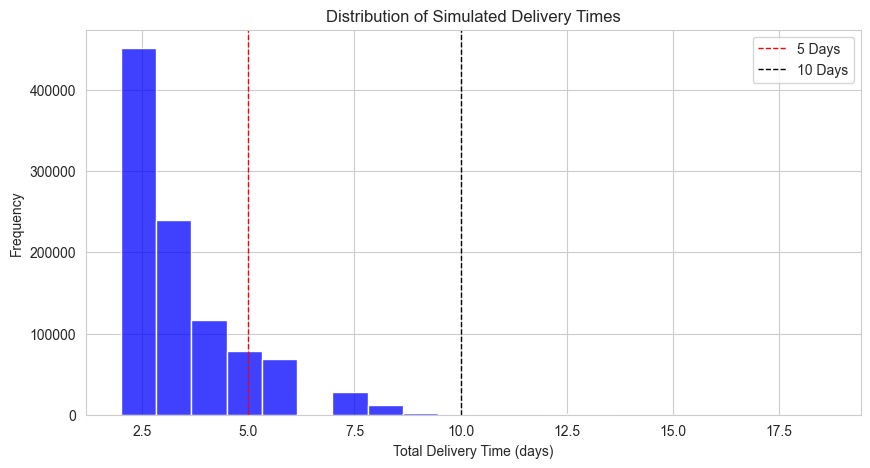

In [10]:
# Visualization
plt.figure(figsize=(10,5))
sns.histplot(delivery_times, bins=20, kde=False, color='blue')
plt.axvline(5, color='red', linestyle='dashed', linewidth=1, label='5 Days')
plt.axvline(10, color='black', linestyle='dashed', linewidth=1, label='10 Days')
plt.xlabel('Total Delivery Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Simulated Delivery Times')
plt.legend()
plt.show()

---

### Interpretation

The graph shows the distribution of simulated delivery times across all parcels. The x-axis represents the total delivery time in days, while the y-axis shows how frequently each delivery duration occurred. The tall blue spike near 2 days indicates that most deliveries arrive without delay, reflecting the baseline delivery time. As delivery time increases, the frequency of parcels delivered at those durations drops sharply, forming a long tail to the right. The dashed vertical lines at 5 and 10 days serve as reference points: the red line (5 days) marks a soft threshold for timely delivery, while the black line (10 days) highlights significantly delayed outliers. The blue density curve gives a smoothed view of the histogram to help spot overall patterns.


From the graph, we can conclude that the simulated delivery system is generally efficient, with the majority of parcels delivered within 2 to 4 days. Delays beyond 5 days are relatively rare, and delays over 10 days are exceptional, likely resulting from the simultaneous occurrence of multiple disruptive events (such as snow and strikes). This suggests the modeled system is robust under typical conditions but becomes vulnerable when disruptions stack. The long tail of the distribution reflects that while extreme delays are possible, they affect only a small fraction of deliveries. This insight can help prioritize contingency planning for high-impact but low-frequency scenarios.

---
### Critical Reflection and Contextualisation